# ***Skin Cancer Detection (Melanoma) using CNN***

Created By : Anupam Maiti

___
<h2>Problem statement</h2>

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

*In this Python Notebbok, we will build a multiclass classification model using a custom convolutional neural network in TensorFlow.*
___

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Importing all the important libraries

In [ ]:
#import the required libraries
import pathlib  # For handling file system paths
import os  # For operating system dependent functionality

import numpy as np  # Numerical computing library
import pandas as pd  # Data analysis and manipulation library
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns  # Statistical data visualization library

import PIL  # Python Imaging Library for image processing

import tensorflow as tf  # Machine learning framework
from tensorflow import keras  # High-level neural networks API
from tensorflow.keras import layers  # Neural network layers
from tensorflow.keras.models import Sequential  # Sequential model for building neural networks

from tensorflow.keras.optimizers import Adam  # Optimization algorithm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  # Callbacks for model training

from tensorflow.keras.preprocessing.image import load_img  # Function for loading images


## Data Reading/Data Understanding

In [ ]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

> This case study utilizes a dataset comprising approximately 2357 images depicting various types of skin cancer. Within both the training and testing directories, there are 9 subdirectories. Each of these subdirectories corresponds to one of the 9 different types of skin cancer, containing images specific to that type.

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [ ]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

# Counting the number of training images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

# Counting the number of testing images
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)


2239
118


## Dataset Creation


Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# Train dataset
#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
# Create a TensorFlow dataset from images in the training directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,                         # Path to the training directory
    validation_split=0.2,                   # Splitting 20% of the data for validation
    subset="training",                      # Specifying that this dataset is for training
    label_mode='categorical',               # Encoding labels in categorical format
    seed=123,                               # Seed for reproducibility
    image_size=(img_height, img_width),     # Desired size of the images
    batch_size=batch_size                   # Size of batches for training
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
# Validation dataset
# Create a TensorFlow dataset from images in the training directory for validation
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,                         # Path to the training directory
    validation_split=0.2,                   # Splitting 20% of the data for validation
    subset="validation",                    # Specifying that this dataset is for validation
    label_mode='categorical',               # Encoding labels in categorical format
    seed=123,                               # Seed for reproducibility
    image_size=(img_height, img_width),     # Desired size of the images
    batch_size=batch_size                   # Size of batches for validation
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


## Data Visualization

Found 2239 files belonging to 9 classes.
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


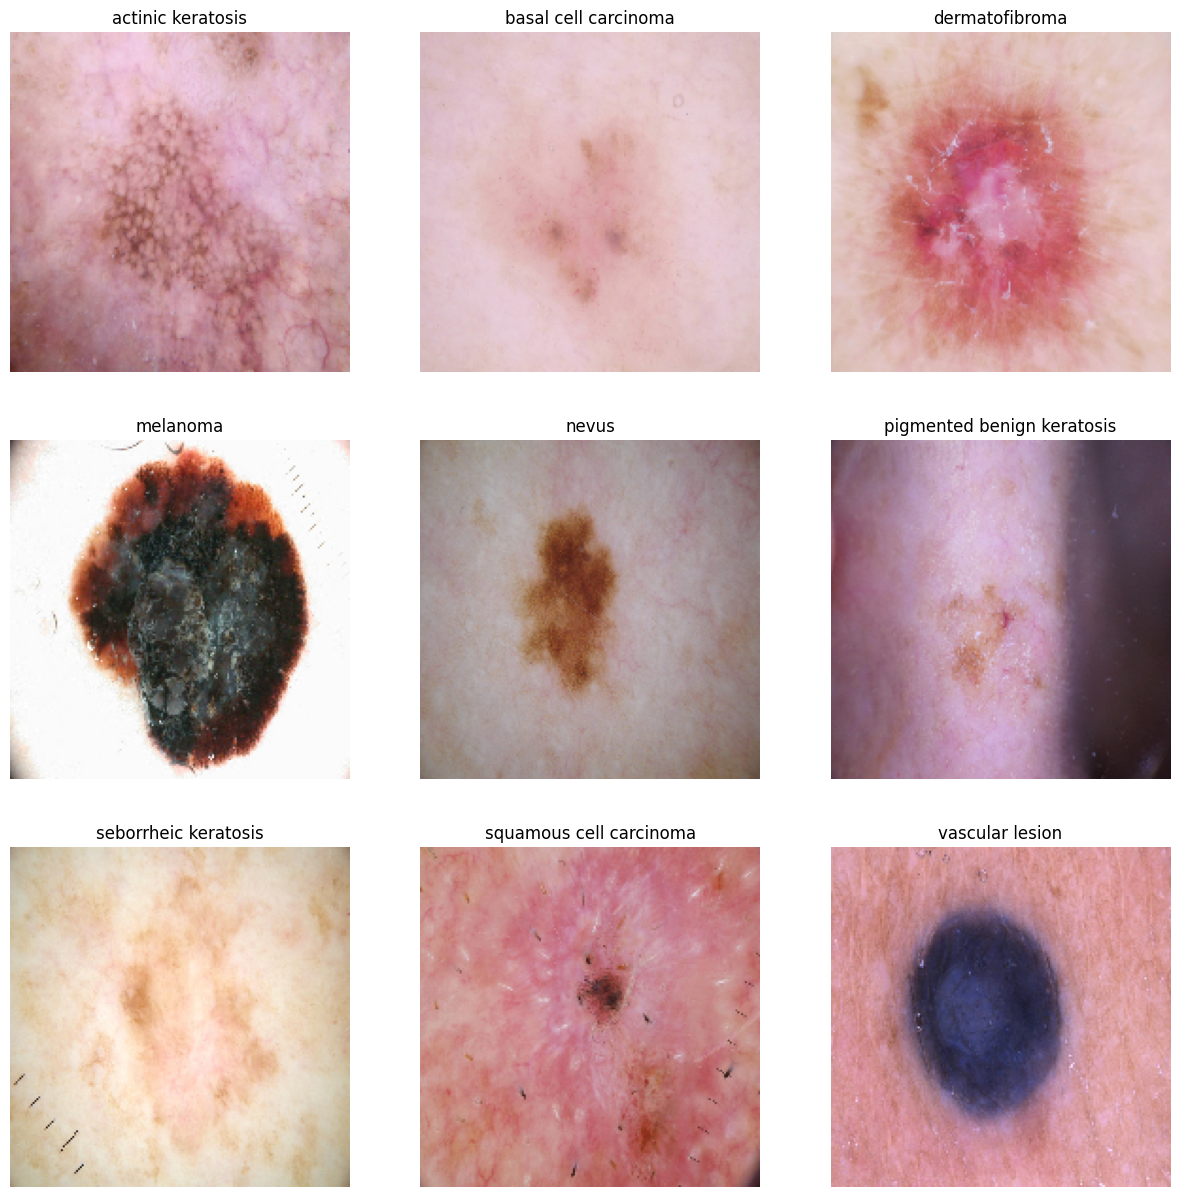

In [ ]:
#Visualize one instance of all the class present in the dataset.
# Create TensorFlow dataset from directory for training images
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,                         # Path to the training directory
    batch_size=batch_size,                  # Size of batches
    image_size=(img_height, img_width),     # Size to resize the images
    label_mode='categorical',               # Encoding labels in categorical format
    seed=123                                # Seed for reproducibility
)

# Get the class names (types of skin cancer)
class_names = image_dataset.class_names
print(class_names)

# Dictionary to store the path of image as per the class
files_path_dict = {}

# Iterate through each class and store paths of images
for c in class_names:
    files_path_dict[c] = list(map(lambda x: str(data_dir_train) + '/' + c + '/' + x, os.listdir(str(data_dir_train) + '/' + c)))

# Visualize images
plt.figure(figsize=(15, 15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]  # Taking only the first image of each class for visualization
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(load_img(path_list[0], target_size=(img_height, img_width)))
    plt.title(c)
    plt.axis("off")


> The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

## Model Building

In [ ]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.
AUTOTUNE = tf.data.experimental.AUTOTUNE  # Define the constant AUTOTUNE for optimization

# Apply caching, shuffling, and prefetching to the training dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Apply caching and prefetching to the validation dataset
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


> Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

> Dataset.prefetch() overlaps data preprocessing and model execution while training.

## Model 1: CNN

### Create CNN Model

In [ ]:
# Define the input shape for the CNN model
input_shape = (img_height, img_width, 3)

# Initialize a Sequential model
model = Sequential()

# Rescale pixel values to the range [0, 1]
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape))

# First Convolutional Layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Third Convolutional Layer
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Flatten layer to convert multi-dimensional input tensors into a single dimension
model.add(layers.Flatten())

# Dense (fully connected) layer with 512 units and ReLU activation function
model.add(layers.Dense(512, activation='relu'))

# Dense (fully connected) layer with 128 units and ReLU activation function
model.add(layers.Dense(128, activation='relu'))

# Output layer with softmax activation function, used for classification
model.add(layers.Dense(len(class_names), activation='softmax'))

# Print summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Vizualizing the model

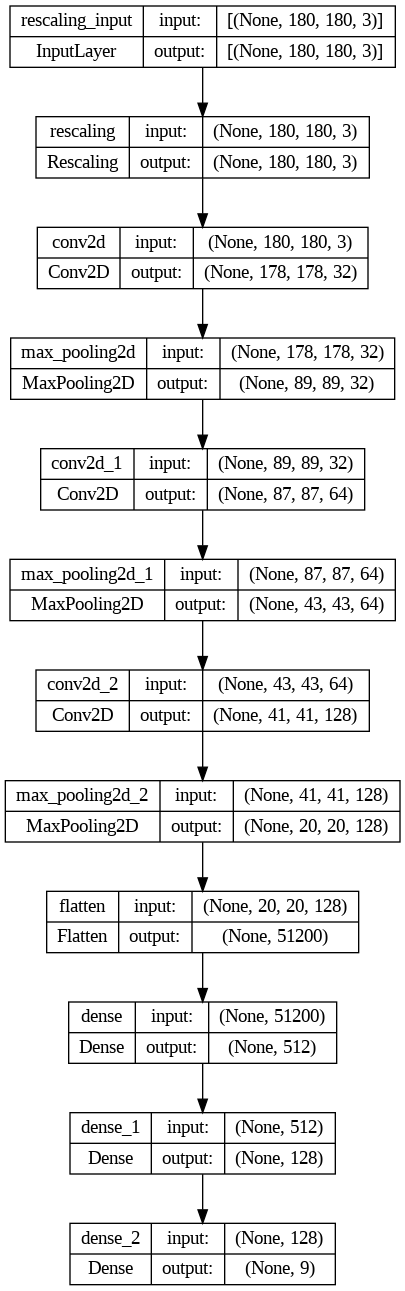

In [ ]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Compile the Model

In [ ]:
#Compile the Model
#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])


### Train the model

In [ ]:
# Train the model
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 23s 100ms/step - loss: 2.1638 - accuracy: 0.2026 - val_loss: 1.8997 - val_accuracy: 0.2841
Epoch 2/20
56/56 [==============================] - 2s 39ms/step - loss: 1.8135 - accuracy: 0.3270 - val_loss: 1.7146 - val_accuracy: 0.3669
Epoch 3/20
56/56 [==============================] - 2s 38ms/step - loss: 1.6415 - accuracy: 0.4074 - val_loss: 1.5565 - val_accuracy: 0.4720
Epoch 4/20
56/56 [==============================] - 2s 41ms/step - loss: 1.5271 - accuracy: 0.4526 - val_loss: 1.4870 - val_accuracy: 0.4586
Epoch 5/20
56/56 [==============================] - 3s 53ms/step - loss: 1.3896 - accuracy: 0.5117 - val_loss: 1.3798 - val_accuracy: 0.5481
Epoch 6/20
56/56 [==============================] - 3s 47ms/step - loss: 1.2898 - accuracy: 0.5502 - val_loss: 1.4197 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 2s 40ms/step - loss: 1.2498 - accuracy: 0.5446 - val_loss: 1.4763 - val_accuracy: 0.4586
Epoch 8/20


### Visualizing training vs test results

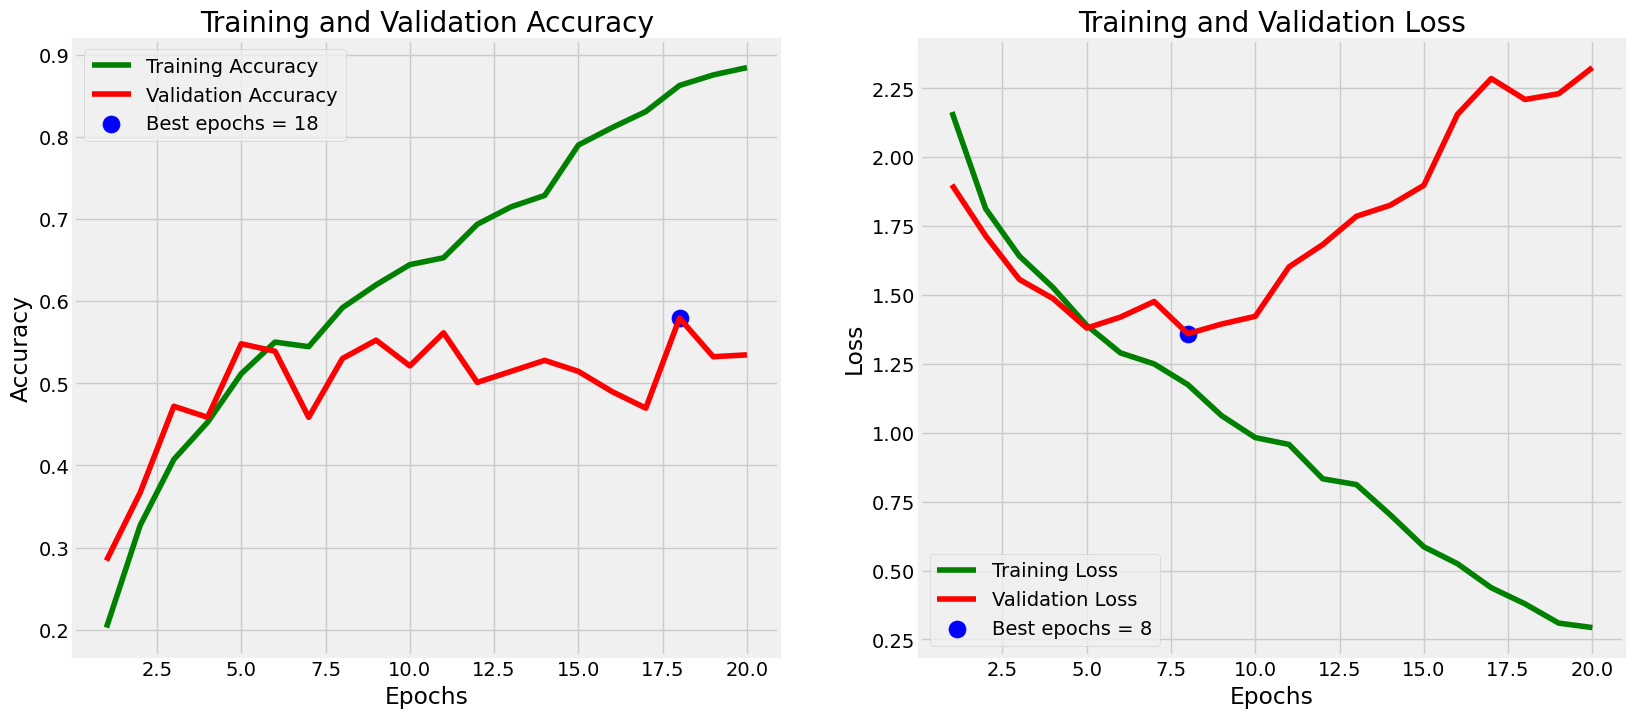

In [ ]:
# Extracting training and validation accuracy and loss from history object
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Finding index of lowest validation loss and highest validation accuracy
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

# Generating list of epochs
Epochs = [i+1 for i in range(len(train_acc))]

# Creating labels for best epochs
loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

# Plotting training and validation accuracy
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_acc , 'g' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'r' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1,2,2)
plt.plot(Epochs , train_loss , 'g' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'r' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout
plt.show();

**<h3> Findings:</h3>**

1. We can clearly observe a drastic difference between Traning and Validation Accuracy, which indicates that the model has overfitted
2. Also we can observe that the validation accuracy the model has achieved is below 55 %

Overall we need to apply techniques like Data Augmentation and Dropout to handle the overfitting issue of the model

## Model 2: CNN with Data Augmentation

In [ ]:
# Define a Sequential model for data augmentation
data_augmentation = keras.Sequential(
    [
        # Randomly flip images horizontally
        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),

        # Randomly rotate images by a fraction of 0.1 radians
        layers.RandomRotation(0.1),

        # Randomly zoom into images by a factor of 0.1
        layers.RandomZoom(0.1),
    ]
)

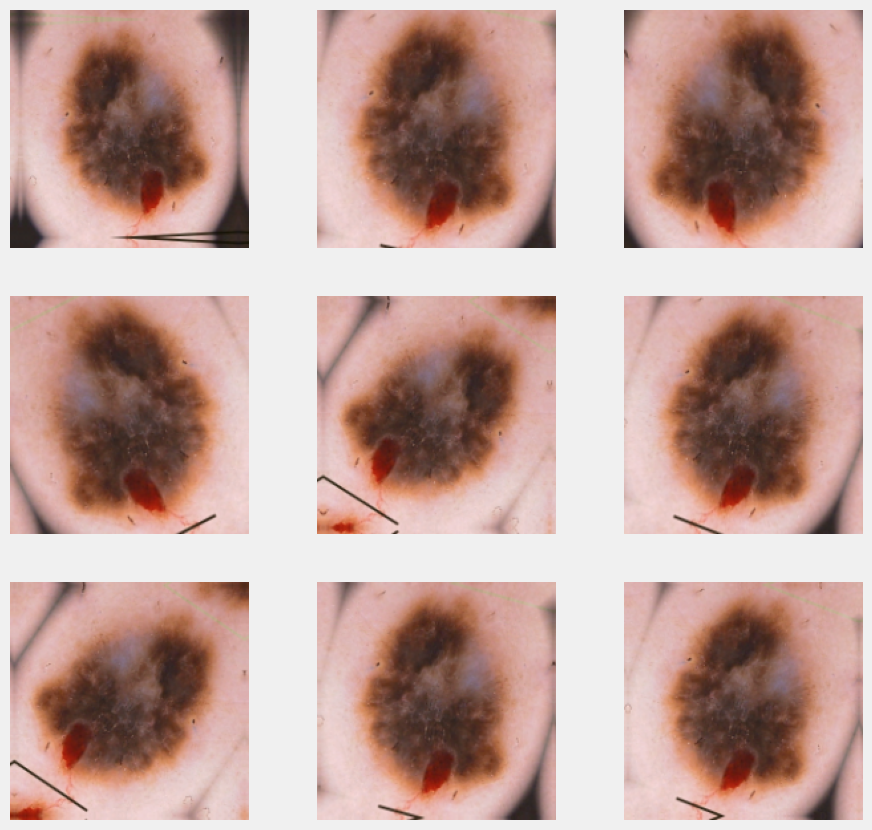

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create CNN Model

In [ ]:
## CNN Model 2 Creation

#Dropout layer: Dropout layers with specified dropout rates are added after each max pooling layer
#               and dense layer to prevent overfitting by randomly dropping a fraction of the input units during training.

model2 = Sequential()  # Initialize a Sequential model

model2.add(data_augmentation)  # Add the data augmentation layer

model2.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape))  # Rescale pixel values

# First Convolutional Layer
model2.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2, 2)))

# Dropout layer with 25% dropout rate
model2.add(layers.Dropout(0.25))

# Second Convolutional Layer
model2.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2, 2)))

# Dropout layer with 25% dropout rate
model2.add(layers.Dropout(0.25))

# Third Convolutional Layer
model2.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2, 2)))

# Flatten layer
model2.add(layers.Flatten())

# Dense Layer
model2.add(layers.Dense(512, activation='relu'))

# Dense Layer
model2.add(layers.Dense(128, activation='relu'))

# Dropout layer with 50% dropout rate
model2.add(layers.Dropout(0.50))

# Output layer with softmax activation function
model2.add(layers.Dense(len(class_names), activation='softmax'))


### Vizualizing the model

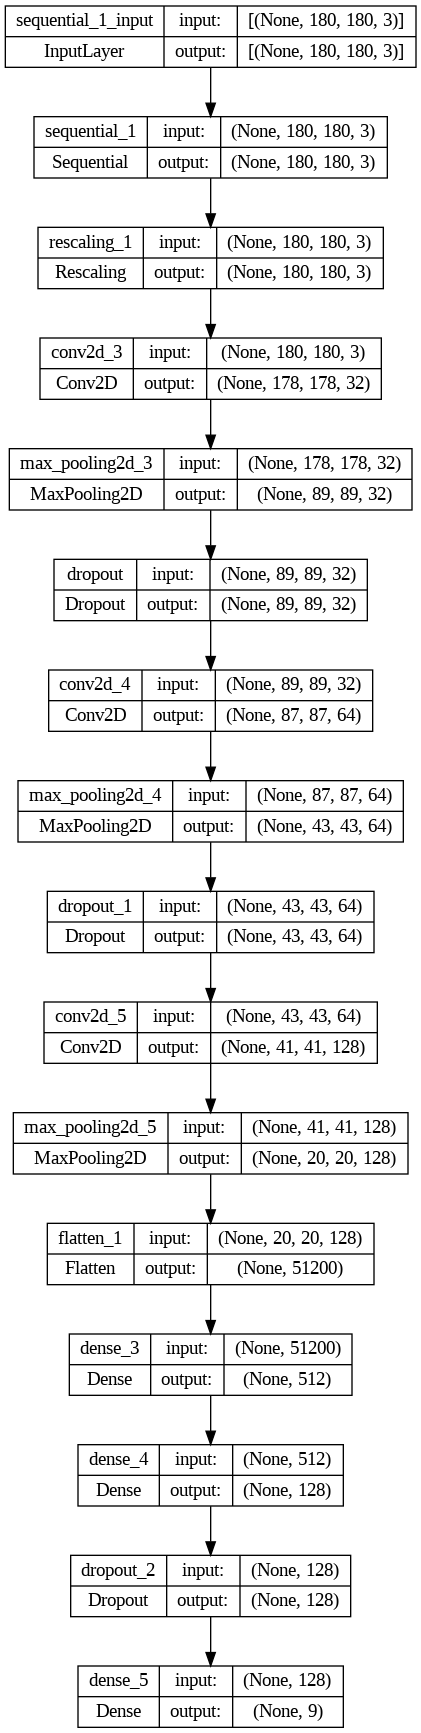

In [ ]:
plot_model(model2, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

### Compile the Model

In [ ]:
# Compiling the model
model2.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

# ModelCheckpoint callback
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# EarlyStopping callback
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

### Train the Model

In [ ]:
# Train the model
epochs = 20
history = model2.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 2.5307 - accuracy: 0.1819
Epoch 1: val_accuracy improved from -inf to 0.27964, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/56 [==============================] - 8s 90ms/step - loss: 2.5307 - accuracy: 0.1819 - val_loss: 2.0691 - val_accuracy: 0.2796
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.9572 - accuracy: 0.2751
Epoch 2: val_accuracy improved from 0.27964 to 0.34004, saving model to model.h5
56/56 [==============================] - 5s 88ms/step - loss: 1.9572 - accuracy: 0.2751 - val_loss: 1.8803 - val_accuracy: 0.3400
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.8210 - accuracy: 0.3510
Epoch 3: val_accuracy did not improve from 0.34004
56/56 [==============================] - 4s 63ms/step - loss: 1.8210 - accuracy: 0.3510 - val_loss: 1.7737 - val_accuracy: 0.3289
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 1.7875 - accuracy: 0.3454
Epoch 4: val_accuracy improved from 0.34004 to 0.40940, saving model to model.h5
56/56 [==============================] - 4s 80ms/step - loss: 1.7875 - accuracy: 0.3454 - val_loss: 1.6450 - val_ac

### Visualizing training vs test results

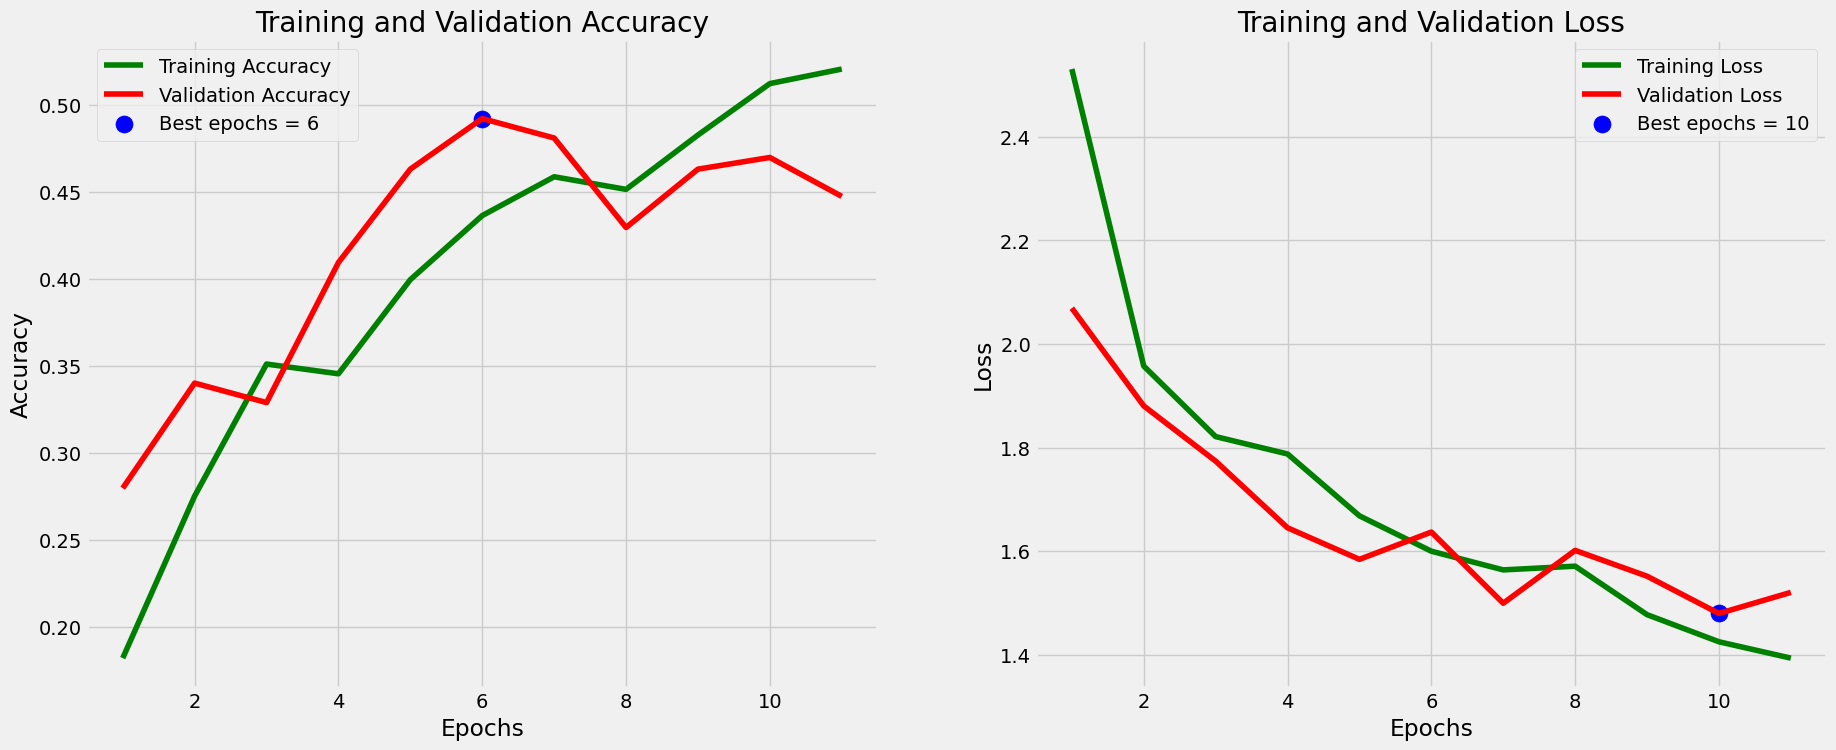

In [ ]:
# Extracting training and validation accuracy and loss from history object
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Finding index of lowest validation loss and highest validation accuracy
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

# Generating list of epochs
Epochs = [i+1 for i in range(len(train_acc))]

# Creating labels for best epochs
loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

# Plotting training and validation accuracy
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_acc , 'g' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'r' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1,2,2)
plt.plot(Epochs , train_loss , 'g' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'r' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout
plt.show();

**<h3> Findings:</h3>**

As we can see that now the Training and Validation accuracy are almost in the same level, this shows the impact of how performing Data Augmentation and dropout layers can improve the model performance.

But we can still try to increase the accuracy of the model.Let's check the distribution of classes in the training set to check is there have class imbalance.

## Model 3: CNN with Class Imbalance

### Visualize Class distribution

Visualize Class distribution of classes in the training dataset.

In [ ]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,melanoma,438
1,squamous cell carcinoma,181
2,pigmented benign keratosis,462
3,basal cell carcinoma,376
4,vascular lesion,139
5,dermatofibroma,95
6,seborrheic keratosis,77
7,nevus,357
8,actinic keratosis,114


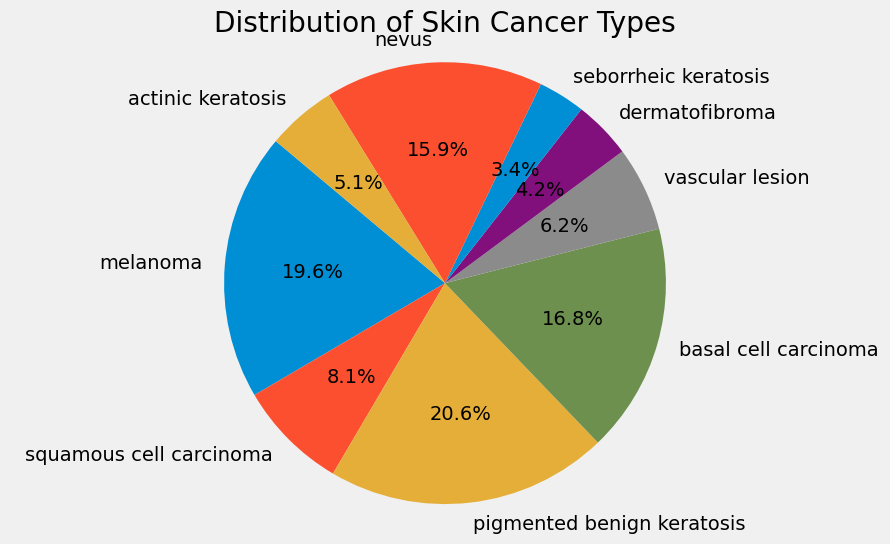

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.title('Distribution of Skin Cancer Types')
sns.set_palette('pastel')
plt.pie(df['No. of Image'], labels=df['Class'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

- Which class has the least number of samples?
  
  From the above chart we can see that the class with label "seborrheic keratosis" has the least number of samples.

- Which classes dominate the data in terms proportionate number of samples?
  
  We can observe that, class with label "pigmented benign keratosis" and "melanoma" has the most number of samples and dominates.

> There is a class imbalance to solve this using a python package Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

### Handling Class Imbalance

In [ ]:
#install Augmentor
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

* Instantiate a Pipeline object pointing to a directory containing your initial image data set.
* Define a number of operations to perform on this data set using your Pipeline object.
* Execute these operations by calling the Pipeline’s sample() method.

In [ ]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CB9326CF340>: 100%|██████████| 500/500 [00:18<00:00, 26.54 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CB940638220>: 100%|██████████| 500/500 [00:19<00:00, 25.77 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CB932F10A00>: 100%|██████████| 500/500 [00:18<00:00, 27.61 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7CB94021B970>: 100%|██████████| 500/500 [01:24<00:00,  5.89 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CB9407463B0>: 100%|██████████| 500/500 [01:26<00:00,  5.75 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CB95B9F2950>: 100%|██████████| 500/500 [00:15<00:00, 32.61 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CB9401D3010>: 100%|██████████| 500/500 [00:34<00:00, 14.32 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CB9404DFE50>: 100%|██████████| 500/500 [00:14<00:00, 34.27 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CB93263C0A0>: 100%|██████████| 500/500 [00:15<00:00, 33.05 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [ ]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

dataframe_dict_new = dict(zip(path_list, lesion_list_new))

#dataframe that store path and label of the images generated by Augmentor
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

#label count.
df2['Label'].value_counts()

melanoma                      500
squamous cell carcinoma       500
pigmented benign keratosis    500
basal cell carcinoma          500
vascular lesion               500
dermatofibroma                500
seborrheic keratosis          500
nevus                         500
actinic keratosis             500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [ ]:
#Training dataset.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,    #20% fraction of data to reserve for validation.
  subset = "training",
  image_size=(img_height, img_width),label_mode='categorical',  #label_mode='categorical' means that the labels are encoded as a categorical vector
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
#validation dataset.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,    #20% fraction of data to reserve for validation.
  subset = "validation",
  image_size=(img_height, img_width),label_mode='categorical',  #label_mode='categorical' means that the labels are encoded as a categorical vector
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Create CNN Model

In [ ]:
#Model 3

model3 = Sequential()

#Rescaling Layer
model3.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))

#First Convulation layer
model3.add(layers.Conv2D(32,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Second Convulation Layer
model3.add(layers.Conv2D(64,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Third Convulation Layer
model3.add(layers.Conv2D(128,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
model3.add(layers.Flatten())

#Dense Layer
model3.add(layers.Dense(512,activation='relu'))

#Dropout layer
model3.add(layers.Dropout(0.25))

#Batch normalization: is a method used to make artificial neural networks faster and more stable through normalization
#of the layers' inputs by re-centering and re-scaling.
model3.add(layers.BatchNormalization())

#Dense Layer
model3.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model3.add(layers.Dropout(0.50))

#Batch normalization
model3.add(layers.BatchNormalization())

#Dense layer with Softmax activation function.
model3.add(layers.Dense(len(class_names),activation='softmax'))

model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 179, 179, 32)      416       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 89, 89, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 88, 88, 64)        8256      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 44, 44, 64)        0         
 g2D)                                                 

### Vizualizing the model

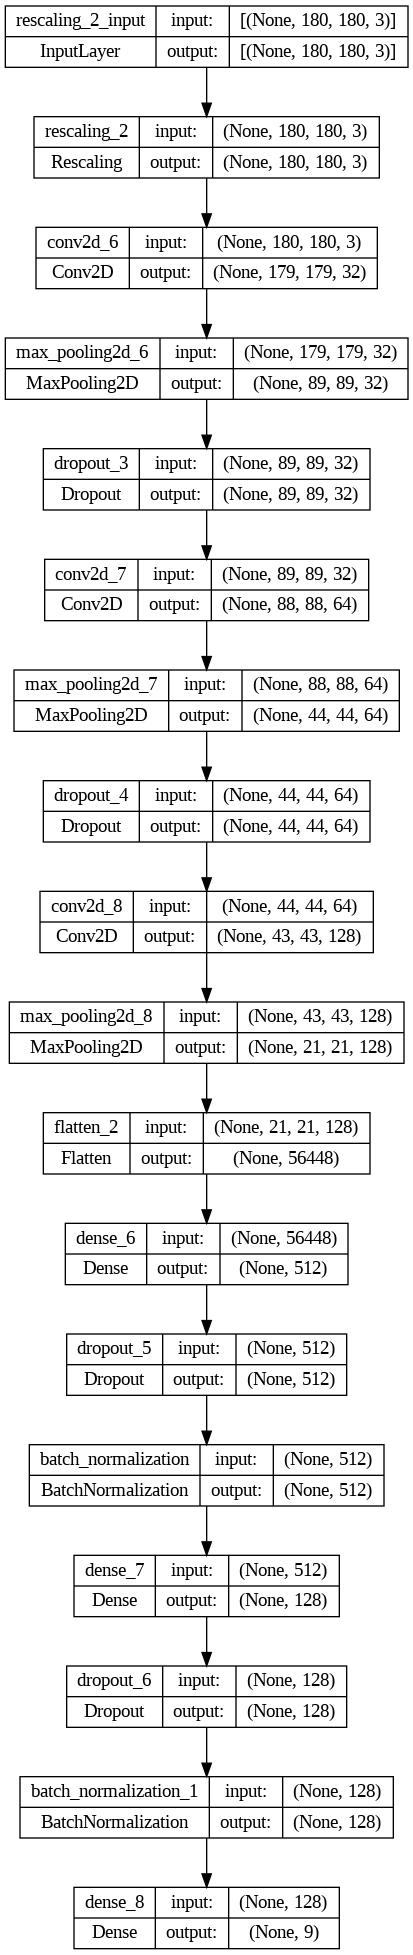

In [ ]:
# vizualizing the model
plot_model(model3, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

### Compile the Model

In [ ]:
#Compile the Model
model3.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback
checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

# EarlyStopping callback
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

### Train the model

In [ ]:
# Train the model
epochs = 30
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint,earlystop]
)

Epoch 1/30
169/169 [==============================] - ETA: 0s - loss: 2.4073 - accuracy: 0.1957
Epoch 1: val_accuracy improved from -inf to 0.14996, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


169/169 [==============================] - 45s 233ms/step - loss: 2.4073 - accuracy: 0.1957 - val_loss: 2.9717 - val_accuracy: 0.1500
Epoch 2/30
168/169 [============================>.] - ETA: 0s - loss: 1.6852 - accuracy: 0.3752
Epoch 2: val_accuracy improved from 0.14996 to 0.20787, saving model to model.h5
169/169 [==============================] - 36s 207ms/step - loss: 1.6860 - accuracy: 0.3750 - val_loss: 2.3133 - val_accuracy: 0.2079
Epoch 3/30
168/169 [============================>.] - ETA: 0s - loss: 1.5067 - accuracy: 0.4321
Epoch 3: val_accuracy improved from 0.20787 to 0.28137, saving model to model.h5
169/169 [==============================] - 28s 163ms/step - loss: 1.5057 - accuracy: 0.4325 - val_loss: 1.8293 - val_accuracy: 0.2814
Epoch 4/30
168/169 [============================>.] - ETA: 0s - loss: 1.4104 - accuracy: 0.4624
Epoch 4: val_accuracy improved from 0.28137 to 0.33036, saving model to model.h5
169/169 [==============================] - 30s 169ms/step - loss: 1

### Visualizing training vs test results

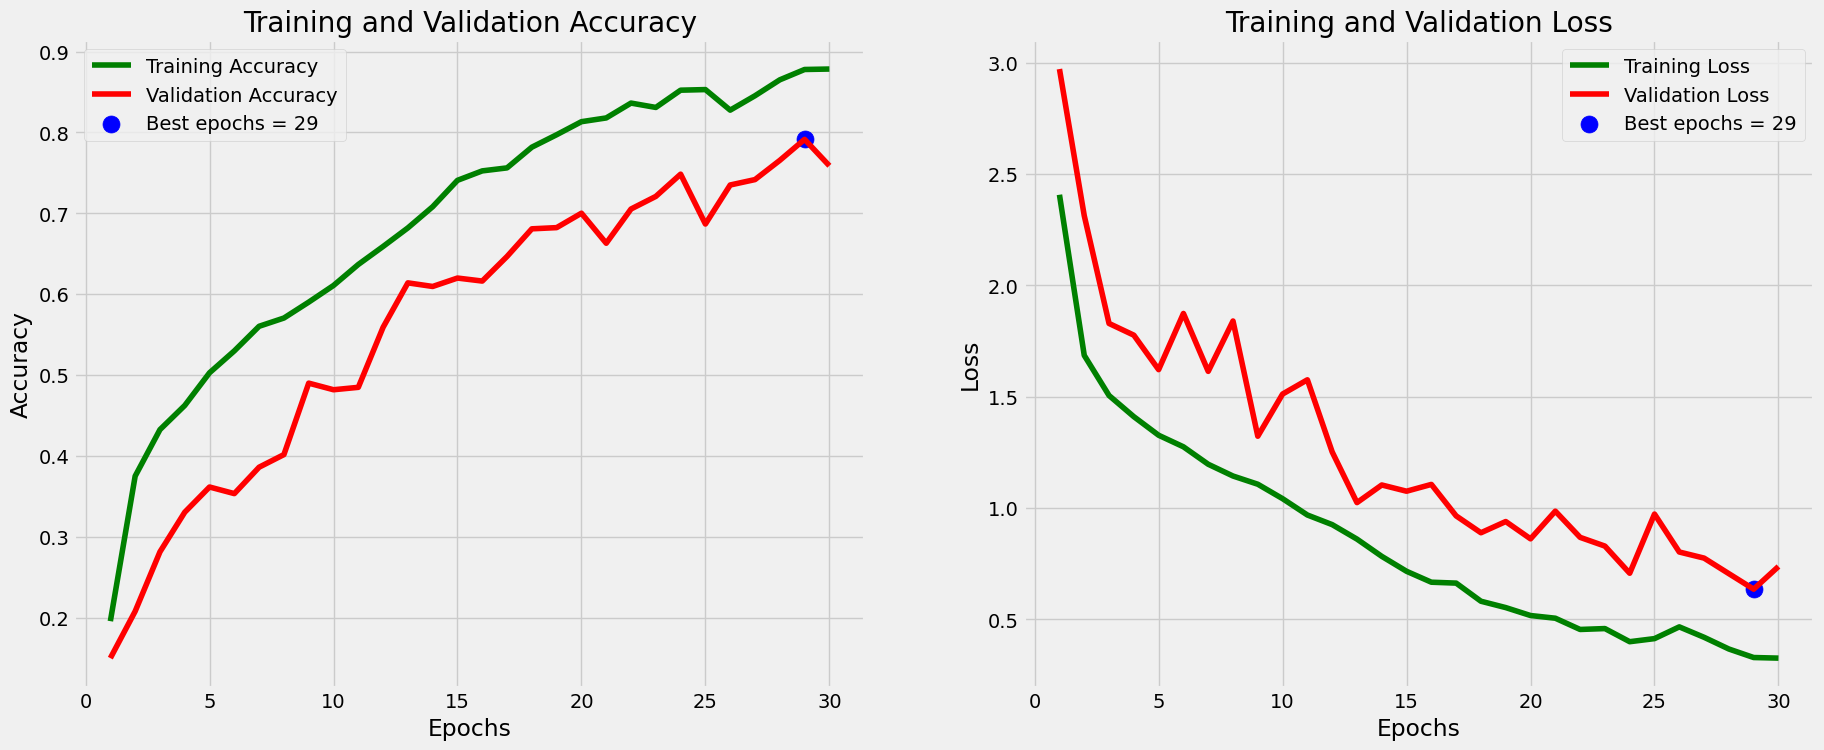

In [ ]:
# Extracting training and validation accuracy and loss from history object
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Finding index of lowest validation loss and highest validation accuracy
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

# Generating list of epochs
Epochs = [i+1 for i in range(len(train_acc))]

# Creating labels for best epochs
loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

# Plotting training and validation accuracy
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_acc , 'g' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'r' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1,2,2)
plt.plot(Epochs , train_loss , 'g' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'r' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout
plt.show();

**<h3> Findings:</h3>**

As per the final model,

* Training accuracy and validation accuracy increases.

* Rectifying the Class Imbalance and performing Data augumentation on the dataset has resulted in a model with higher accuracy and overcoming overfitting.

* The narrow divergence between training and validation accuracies underscores the robust generalization capability of the final CNN model.